<a href="https://colab.research.google.com/github/Nestord19/Parcial2CorteElectiva/blob/main/DiabetesPima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importe de librerias

In [1]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, RocCurveDisplay)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

sns.set(style='whitegrid')
SEED = 42

# Carga de dataset Diabetes 0= No tiene diabetes y 1= Si ti3ne diabetes


Dimensiones: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


,count
Outcome,
no_diabetes,500
diabetes,268


<Figure size 1200x600 with 0 Axes>

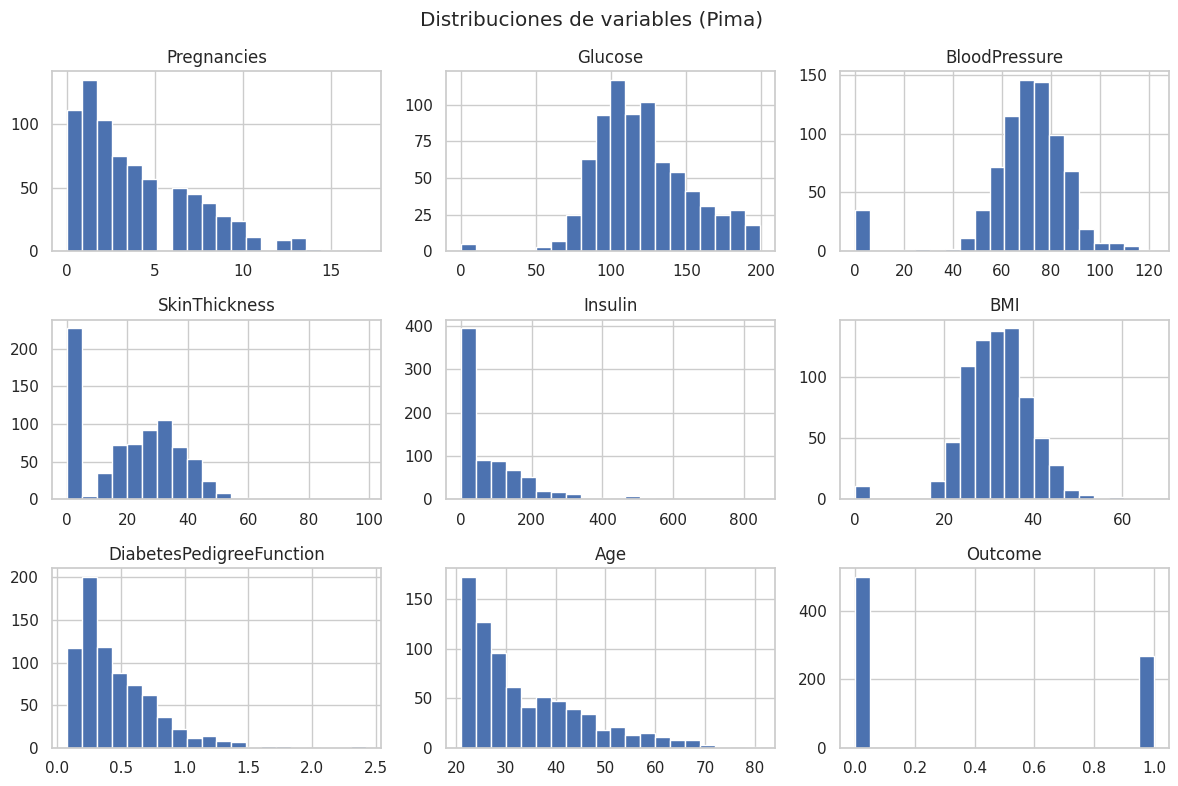

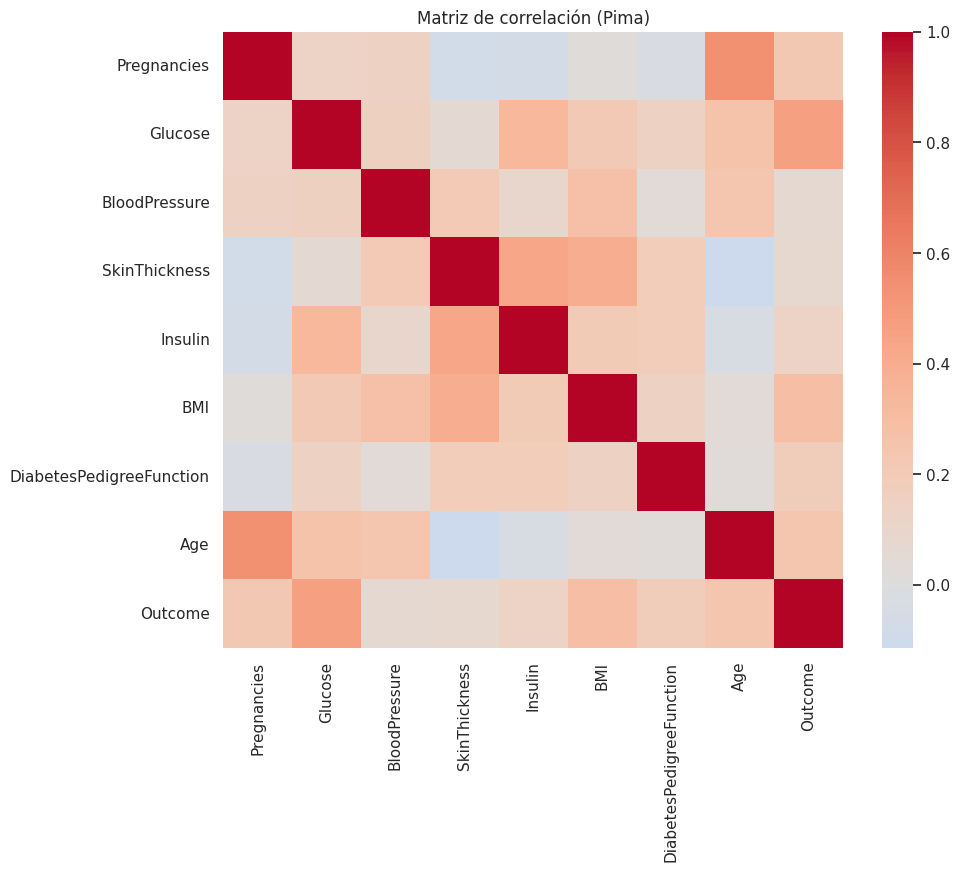

Train shape: (537, 8)
Test shape : (231, 8)
Distribución en train:
Outcome
no_diabetes    0.652
diabetes       0.348
Name: proportion, dtype: float64


In [2]:
# 1 · Carga del dataset Pima Indians Diabetes
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
df = pd.read_csv(url, header=None, names=cols)

print("Dimensiones:", df.shape)
print(df.head())

# 1.1 · EDA rápido y distribución de clases
display(df.describe().T)
display(df['Outcome'].value_counts().rename(index={0:'no_diabetes',1:'diabetes'}))

# Visualizaciones
plt.figure(figsize=(12, 6))
df.hist(bins=20, figsize=(12,8))
plt.suptitle("Distribuciones de variables (Pima)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Matriz de correlación (Pima)")
plt.show()

# 1.2 · Preparación de X e y, split estratificado
X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Distribución en train:")
print(y_train.value_counts(normalize=True).rename(index={0:'no_diabetes',1:'diabetes'}).round(3))


In [3]:

# 2 · Fundamentos: Entropía y Gini
def entropy(labels):
    counts = Counter(labels)
    total = len(labels)
    return -sum((count / total) * math.log2(count / total) for count in counts.values())

def gini(labels):
    counts = Counter(labels)
    total = len(labels)
    return 1.0 - sum((count / total) ** 2 for count in counts.values())

sample = [0]*90 + [1]*10
left = [0]*65 + [1]*5
right = [0]*25 + [1]*5

print("Entropy root:", round(entropy(sample), 4))
print("Gini root   :", round(gini(sample), 4))
weighted_entropy = (len(left)/len(sample))*entropy(left) + (len(right)/len(sample))*entropy(right)
weighted_gini = (len(left)/len(sample))*gini(left) + (len(right)/len(sample))*gini(right)
print("Weighted entropy after split:", round(weighted_entropy,4))
print("Gain approx:", round(entropy(sample)-weighted_entropy,4))
print("Weighted gini after split:", round(weighted_gini,4))
print("Gini reduction approx:", round(gini(sample)-weighted_gini,4))

# 2.1 · Función auxiliar entrenamiento y evaluacion
model_registry = {}

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

def train_and_evaluate(name, estimator):
    start = time.time()
    fitted = clone(estimator).fit(X_train, y_train)
    elapsed = time.time() - start

    y_pred = fitted.predict(X_test)
    y_proba = fitted.predict_proba(X_test)[:,1] if hasattr(fitted, "predict_proba") else None

    metrics = {
        "train_time_sec": elapsed,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")
    }

    cv_results = cross_validate(clone(estimator), X, y, cv=5, scoring=scoring, n_jobs=-1)
    metrics.update({
        "cv_accuracy_mean": cv_results["test_accuracy"].mean(),
        "cv_accuracy_std": cv_results["test_accuracy"].std(),
        "cv_precision_mean": cv_results["test_precision"].mean(),
        "cv_recall_mean": cv_results["test_recall"].mean(),
        "cv_f1_mean": cv_results["test_f1"].mean()
    })

    report = classification_report(y_test, y_pred, target_names=['no_diabetes','diabetes'], digits=3)

    model_registry[name] = {
        "estimator": fitted,
        "metrics": metrics,
        "confusion": confusion_matrix(y_test, y_pred),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "classification_report": report
    }

    print(name)
    print("-" * len(name))
    print(f"Tiempo de entrenamiento: {metrics['train_time_sec']:.3f} s")
    print(f"Accuracy (test): {metrics['accuracy']:.4f}")
    print(f"Precision (test): {metrics['precision']:.4f}")
    print(f"Recall (test): {metrics['recall']:.4f}")
    print(f"F1 (test): {metrics['f1']:.4f}")
    if not math.isnan(metrics['roc_auc']):
        print(f"ROC AUC (test): {metrics['roc_auc']:.4f}")
    print(f"CV accuracy (media ± std): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
    print("\\nReporte de clasificación (test):\\n", report)

    return model_registry[name]


Entropy root: 0.469
Gini root   : 0.18
Weighted entropy after split: 0.4549
Gain approx: 0.0141
Weighted gini after split: 0.1762
Gini reduction approx: 0.0038


Árbol de Decisión (pre-podado)
------------------------------
Tiempo de entrenamiento: 0.011 s
Accuracy (test): 0.7619
Precision (test): 0.6857
Recall (test): 0.5926
F1 (test): 0.6358
ROC AUC (test): 0.7901
CV accuracy (media ± std): 0.7292 ± 0.0297
\nReporte de clasificación (test):\n               precision    recall  f1-score   support

 no_diabetes      0.795     0.853     0.823       150
    diabetes      0.686     0.593     0.636        81

    accuracy                          0.762       231
   macro avg      0.740     0.723     0.729       231
weighted avg      0.757     0.762     0.757       231



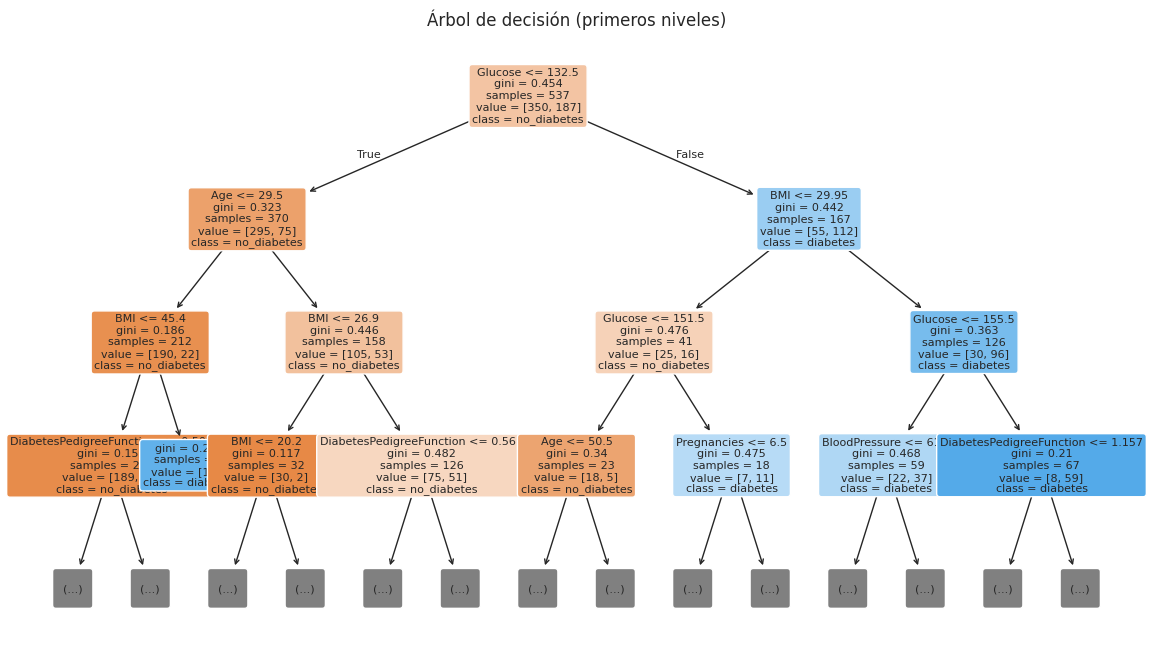

In [4]:
# 3 · Árbol de Decisión (pre-podado)
dt = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=5, random_state=SEED)
train_and_evaluate("Árbol de Decisión (pre-podado)", dt)

# Visualizar primeros niveles
dt_model = model_registry["Árbol de Decisión (pre-podado)"]["estimator"]
plt.figure(figsize=(14,8))
plot_tree(dt_model, feature_names=X.columns, class_names=['no_diabetes','diabetes'], filled=True, rounded=True, fontsize=8, max_depth=3)
plt.title("Árbol de decisión (primeros niveles)")
plt.show()


In [5]:
# 4 · Bagging
bagging = BaggingClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, random_state=SEED, oob_score=True)
train_and_evaluate("Bagging (árboles completos)", bagging)
try:
    print(f"OOB score aproximado: {model_registry['Bagging (árboles completos)']['estimator'].oob_score_:.4f}")
except Exception as e:
    print('OOB no disponible:', e)


Bagging (árboles completos)
---------------------------
Tiempo de entrenamiento: 2.490 s
Accuracy (test): 0.7532
Precision (test): 0.6875
Recall (test): 0.5432
F1 (test): 0.6069
ROC AUC (test): 0.8328
CV accuracy (media ± std): 0.7670 ± 0.0291
\nReporte de clasificación (test):\n               precision    recall  f1-score   support

 no_diabetes      0.778     0.867     0.820       150
    diabetes      0.688     0.543     0.607        81

    accuracy                          0.753       231
   macro avg      0.733     0.705     0.714       231
weighted avg      0.747     0.753     0.745       231

OOB score aproximado: 0.7616


Random Forest
-------------
Tiempo de entrenamiento: 0.872 s
Accuracy (test): 0.7576
Precision (test): 0.6923
Recall (test): 0.5556
F1 (test): 0.6164
ROC AUC (test): 0.8260
CV accuracy (media ± std): 0.7696 ± 0.0313
\nReporte de clasificación (test):\n               precision    recall  f1-score   support

 no_diabetes      0.783     0.867     0.823       150
    diabetes      0.692     0.556     0.616        81

    accuracy                          0.758       231
   macro avg      0.738     0.711     0.720       231
weighted avg      0.751     0.758     0.750       231

OOB score aproximado: 0.7635


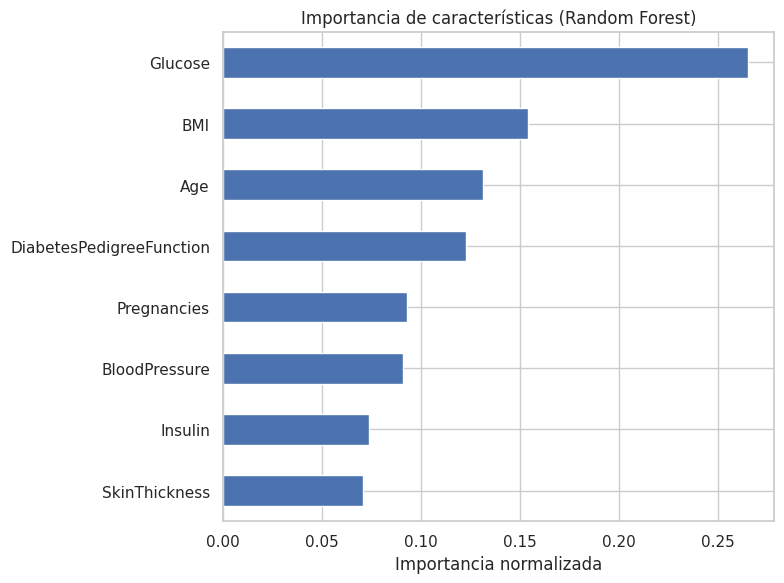

In [6]:
# 5 · Random Forest
rf = RandomForestClassifier(n_estimators=300, max_features='sqrt', random_state=SEED, n_jobs=-1, oob_score=True)
train_and_evaluate("Random Forest", rf)
try:
    print(f"OOB score aproximado: {model_registry['Random Forest']['estimator'].oob_score_:.4f}")
except Exception as e:
    print('OOB no disponible:', e)

# Importancia de características relaciaonado a random forest
rf_model = model_registry['Random Forest']['estimator']
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(12)
plt.figure(figsize=(8,6))
top_features.sort_values().plot(kind='barh')
plt.title('Importancia de características (Random Forest)')
plt.xlabel('Importancia normalizada')
plt.tight_layout()
plt.show()


Gradient Boosting
-----------------
Tiempo de entrenamiento: 0.468 s
Accuracy (test): 0.7576
Precision (test): 0.6923
Recall (test): 0.5556
F1 (test): 0.6164
ROC AUC (test): 0.8416
CV accuracy (media ± std): 0.7773 ± 0.0186
\nReporte de clasificación (test):\n               precision    recall  f1-score   support

 no_diabetes      0.783     0.867     0.823       150
    diabetes      0.692     0.556     0.616        81

    accuracy                          0.758       231
   macro avg      0.738     0.711     0.720       231
weighted avg      0.751     0.758     0.750       231



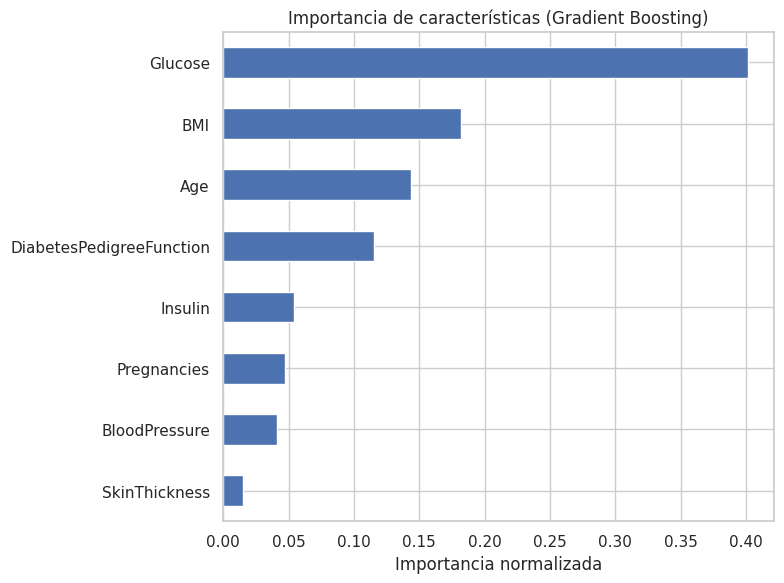

In [7]:
# 6 · Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=SEED)
train_and_evaluate("Gradient Boosting", gb)

# Importancia de características relacionado a gradient
gb_model = model_registry['Gradient Boosting']['estimator']
importances_gb = pd.Series(gb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(8,6))
importances_gb.sort_values(ascending=False).head(12).sort_values().plot(kind='barh')
plt.title('Importancia de características (Gradient Boosting)')
plt.xlabel('Importancia normalizada')
plt.tight_layout()
plt.show()

,accuracy,precision,recall,f1,roc_auc,train_time_sec,cv_accuracy_mean,cv_accuracy_std
Árbol de Decisión (pre-podado),0.7619,0.6857,0.5926,0.6358,0.7901,0.0112,0.7292,0.0297
Random Forest,0.7576,0.6923,0.5556,0.6164,0.8260,0.8715,0.7696,0.0313
Gradient Boosting,0.7576,0.6923,0.5556,0.6164,0.8416,0.4679,0.7773,0.0186
Bagging (árboles completos),0.7532,0.6875,0.5432,0.6069,0.8328,2.4901,0.7670,0.0291


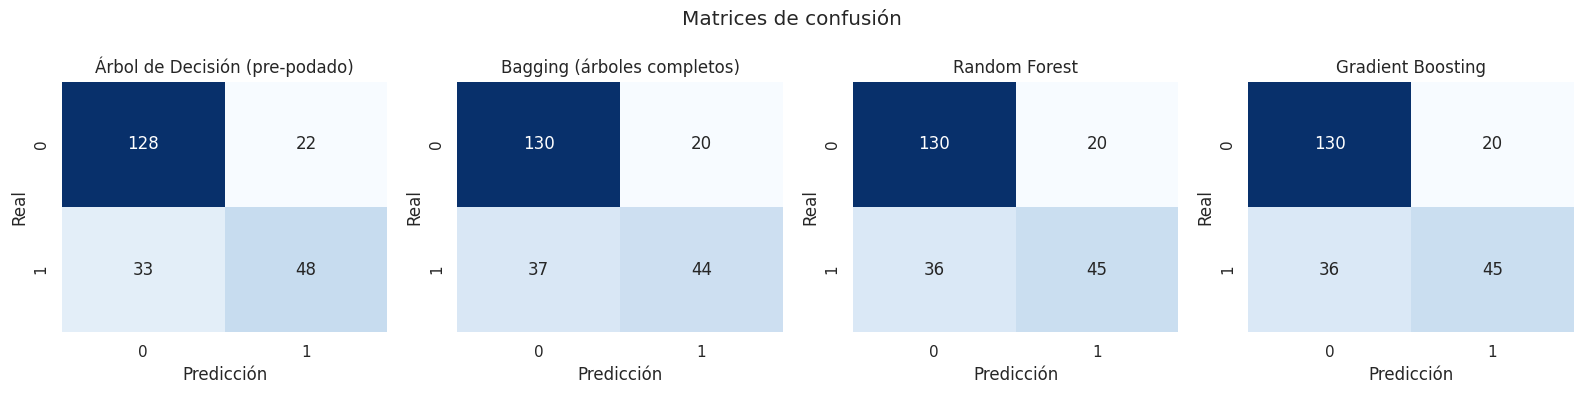

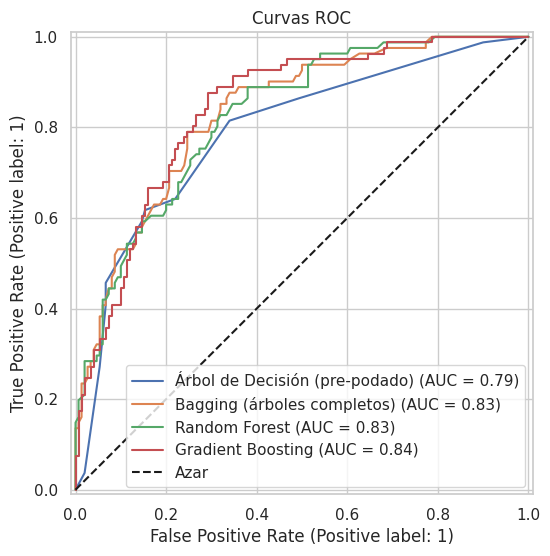

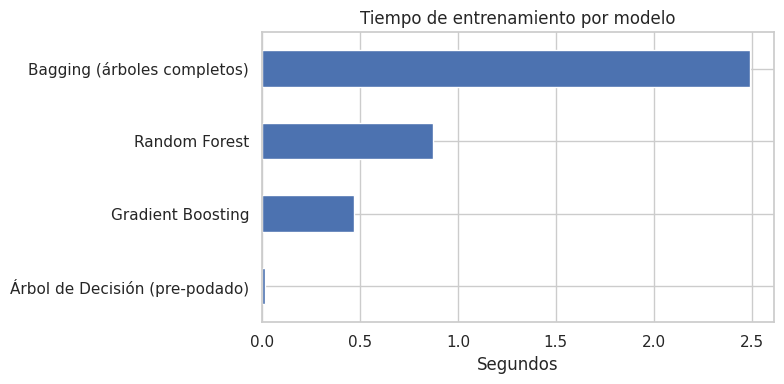

In [8]:
# 7 · Resumen
summary = pd.DataFrame({name: data['metrics'] for name, data in model_registry.items()}).T
cols = ['accuracy','precision','recall','f1','roc_auc','train_time_sec','cv_accuracy_mean','cv_accuracy_std']
summary = summary[cols].sort_values('accuracy', ascending=False)
display(summary.style.format({c: '{:.4f}' for c in cols}))

# Matrices de confusión
fig, axes = plt.subplots(1, len(model_registry), figsize=(16, 4))
if len(model_registry) == 1:
    axes = [axes]
for ax, (name, data) in zip(axes, model_registry.items()):
    sns.heatmap(data['confusion'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
plt.suptitle('Matrices de confusión')
plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(8,6))
for name, data in model_registry.items():
    if data['y_proba'] is None:
        continue
    RocCurveDisplay.from_predictions(y_test, data['y_proba'], name=name, ax=plt.gca())
plt.plot([0,1],[0,1],'k--', label='Azar')
plt.title('Curvas ROC')
plt.legend(loc='lower right')
plt.show()

# Tiempo de entrenamiento
plt.figure(figsize=(8,4))
summary['train_time_sec'].sort_values().plot(kind='barh')
plt.xlabel('Segundos')
plt.title('Tiempo de entrenamiento por modelo')
plt.tight_layout()
plt.show()